In [1]:
import numpy as np
np.object=object
np.bool=bool
np.int=int
import pandas as pd
import tensorflow as tf
import math
from keras.models import Sequential
from keras.layers import Input, Conv2D, concatenate, LSTM, Dense, Dropout, Flatten,RepeatVector,Reshape
from keras.layers import Conv2D
from keras.optimizers import adam_v2
from keras.layers import Input, concatenate
from matplotlib import pyplot as plt
from keras.models import Model
import os

os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

In [2]:
def mean_squared_error(x, y):
    sum = 0
    n = len(x)
    for i, j in zip(x, y):
        sum = sum + (i - j) ** 2
    return sum / n

In [3]:
def score(x, y):
    sum = 0
    for i, j in zip(x, y):
        z = i - j
        if z < 0:
            sum = sum + np.e ** (-z / 13) - 1
        else:
            sum = sum + np.e ** (z / 10) - 1
    return sum

In [4]:
if __name__ == '__main__':
    # 构建训练数据
    df = pd.read_pickle(r'C:\data\train_FD001.pickle')
    train_input = df.iloc[:, :-2].values.reshape(-1, 30, 15, 1)
    train_output = df.iloc[:, -1].values.reshape(-1, )
    # 构建测试数据
    df = pd.read_pickle(r'C:\data\test_FD001.pickle')
    df1 = []
    df2 = []
    for i in range(100):
        df1.append(df[df.unit == i + 1].iloc[-1, :-2].values)
        df2.append(df[df.unit == i + 1].iloc[-1, -1])
    test_input = np.array(df1).reshape(-1, 30, 15, 1)
    test_output = np.array(df2).reshape(-1, )

In [5]:
input_0 = Input(shape=(30,15,1))
# Path 1: LSTM
input_lstm = Reshape((30,15))(input_0)
lstm_1 = LSTM(units=10, return_sequences=False)(input_lstm)
dropout_lstm = Dropout(0.5)(lstm_1)

# Path 2: CNN
input_cnn = Reshape((30,15,1))(input_0)
conv3 = Conv2D(filters=10, kernel_size=(10, 1), strides=(1, 1), padding='same', activation='tanh')(input_cnn)
conv4 = Conv2D(filters=10, kernel_size=(10, 1), strides=(1, 1), padding='same', activation='tanh')(conv3)
conv5 = Conv2D(filters=1, kernel_size=(3, 1), strides=(1, 1), padding='same', activation='tanh',
               name='conv5')(conv4)
dropout_cnn = Dropout(0.5)(conv5)
flatten = Flatten()(dropout_cnn)
dropout2 = Dropout(0.5)(flatten)
dense1 = Dense(100, activation='tanh')(dropout2)

# Repeat LSTM output to match CNN output length
repeat_vec = RepeatVector(1)(dropout_lstm)

# Reshape both inputs to 3D tensors before concatenation
reshape_lstm = Reshape((1,10))(repeat_vec)
reshape_dense = Reshape((-1,100))(dense1)

# Merge paths 1 and 2
merged = concatenate([reshape_lstm, reshape_dense])
lstm_3 = LSTM(units=50, return_sequences=False)(merged)
dropout_lstm_3 = Dropout(0.5)(lstm_3)
output = Dense(1, name='out')(dropout_lstm_3)

model = Model(inputs=[input_0], outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 15, 1)]  0           []                               
                                                                                                  
 reshape_1 (Reshape)            (None, 30, 15, 1)    0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 30, 15, 10)   110         ['reshape_1[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)              (None, 30, 15, 10)   1010        ['conv2d[0][0]']                 
                                                                                              

In [6]:
adam = adam_v2.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08)
model.compile(loss='mse', optimizer=adam)
history1 = model.fit(train_input, train_output,batch_size=256, epochs=250, shuffle=True)
adam = adam_v2.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='mse', optimizer=adam)
history2 = model.fit(train_input, train_output, validation_split=0.33, batch_size=256, epochs=50, shuffle=True)

Epoch 1/250
70/70 [==============================] - 8s 59ms/step - loss: 7435.2285
Epoch 2/250
70/70 [==============================] - 4s 59ms/step - loss: 6640.6748
Epoch 3/250
70/70 [==============================] - 4s 58ms/step - loss: 6218.7563
Epoch 4/250
70/70 [==============================] - 6s 90ms/step - loss: 5856.3013
Epoch 5/250
70/70 [==============================] - 7s 93ms/step - loss: 5524.8662
Epoch 6/250
70/70 [==============================] - 6s 92ms/step - loss: 5204.7808
Epoch 7/250
70/70 [==============================] - 6s 83ms/step - loss: 4908.1665
Epoch 8/250
70/70 [==============================] - 6s 84ms/step - loss: 4637.9570
Epoch 9/250
70/70 [==============================] - 5s 76ms/step - loss: 4375.9697
Epoch 10/250
70/70 [==============================] - 5s 76ms/step - loss: 4122.5298
Epoch 11/250
70/70 [==============================] - 6s 81ms/step - loss: 3888.1899
Epoch 12/250
70/70 [==============================] - 6s 79ms/step - loss:

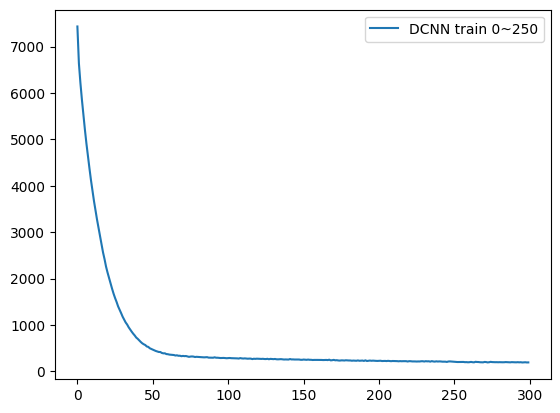

In [7]:

plt.plot((history1.history['loss']) + (history2.history['loss']), label='DCNN train 0~250')
plt.legend(loc='upper right')
plt.show()

4/4 [==============================] - 0s 4ms/step
test rmse: 15.249965480077478
test score: [450.8337]


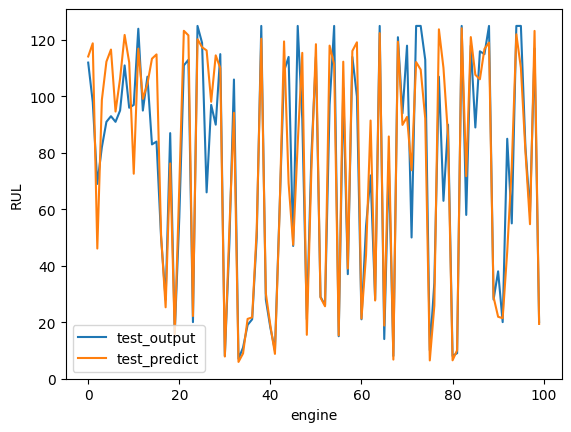

In [9]:
    # 保存预测值，RMSE，得分
test_predict = model.predict(test_input)
RMSE = math.sqrt(mean_squared_error(test_output, test_predict))
SCORE = score(test_output, test_predict)
print("test rmse:", RMSE)
print("test score:", SCORE)
plt.plot(test_output, label='test_output')
plt.plot(test_predict, label='test_predict')
plt.ylabel("RUL")
plt.xlabel("engine")
plt.legend()
plt.show()

In [10]:
test_output

array([112.,  98.,  69.,  82.,  91.,  93.,  91.,  95., 111.,  96.,  97.,
       124.,  95., 107.,  83.,  84.,  50.,  28.,  87.,  16.,  57., 111.,
       113.,  20., 125., 119.,  66.,  97.,  90., 115.,   8.,  48., 106.,
         7.,  11.,  19.,  21.,  50., 125.,  28.,  18.,  10.,  59., 109.,
       114.,  47., 125.,  92.,  21.,  79., 114.,  29.,  26.,  97., 125.,
        15., 103.,  37., 114., 100.,  21.,  54.,  72.,  28., 125.,  14.,
        77.,   8., 121.,  94., 118.,  50., 125., 125., 113.,  10.,  34.,
       107.,  63.,  90.,   8.,   9., 125.,  58., 118.,  89., 116., 115.,
       125.,  28.,  38.,  20.,  85.,  55., 125., 125.,  82.,  59., 117.,
        20.])

In [11]:
test_predict

array([[114.16175  ],
       [118.83684  ],
       [ 46.08262  ],
       [ 98.79922  ],
       [112.33461  ],
       [116.62617  ],
       [ 94.64783  ],
       [106.305305 ],
       [121.80032  ],
       [112.06168  ],
       [ 72.60391  ],
       [116.923935 ],
       [ 99.14468  ],
       [104.476585 ],
       [113.38884  ],
       [114.89877  ],
       [ 50.87299  ],
       [ 25.254648 ],
       [ 76.25358  ],
       [ 15.713314 ],
       [ 67.91823  ],
       [123.26875  ],
       [121.662476 ],
       [ 22.150711 ],
       [120.278496 ],
       [117.44981  ],
       [116.31417  ],
       [ 98.10447  ],
       [114.56578  ],
       [110.03315  ],
       [  7.8093443],
       [ 53.16956  ],
       [ 94.21074  ],
       [  5.8929825],
       [  8.901869 ],
       [ 21.141506 ],
       [ 21.684036 ],
       [ 52.869274 ],
       [120.47064  ],
       [ 30.206707 ],
       [ 18.758678 ],
       [  8.742727 ],
       [ 58.011635 ],
       [119.50251  ],
       [ 69.273865 ],
       [ 4

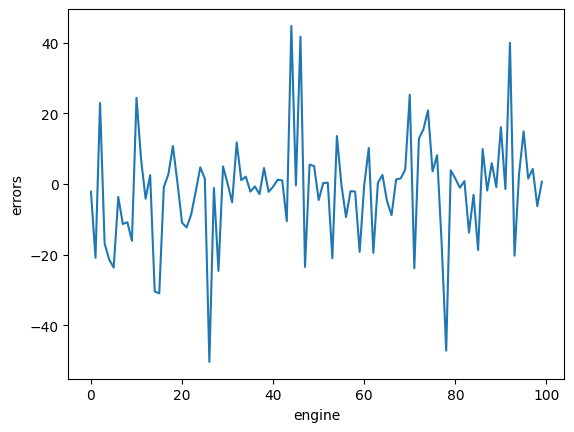

In [12]:
# 计算两个数组的差值
errors = test_output - test_predict.flatten()

# 绘制差值图
plt.plot(range(len(errors)), errors)
plt.ylabel("errors")
plt.xlabel("engine")
plt.show()

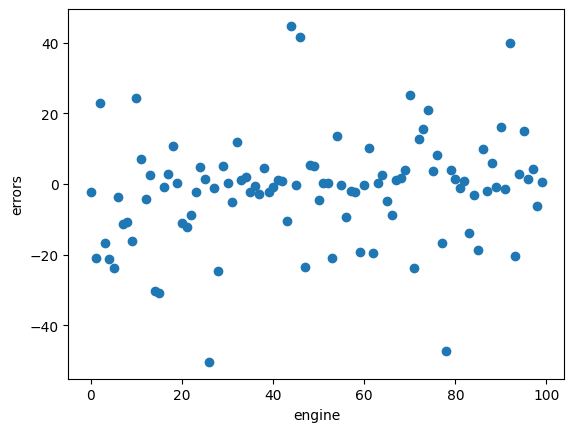

In [13]:
import matplotlib.pyplot as plt

# 计算两个数组的差值
errors = test_output - test_predict.flatten()

# 绘制散点图
plt.scatter(range(len(errors)), errors)
plt.ylabel("errors")
plt.xlabel("engine")
plt.show()


In [14]:
def DrawUnit(df, No, model):
    test_input = df[df.unit == No].iloc[:, :-2].values.reshape((-1, 30, 15, 1))
    test_output = df[df.unit == No].iloc[:, -1].values.reshape(-1, )
    test_predict = model.predict(test_input)
    plt.figure(1, figsize=(15, 9))
    plt.title('test unit #' + str(No))
    plt.plot(test_output, 'ob', ms=3)
    plt.plot(test_output, 'b', lw=2, label='actual')
    plt.legend(loc='lower left')
    plt.plot(test_predict, 'or', ms=3)
    plt.plot(test_predict, 'r', lw=2, label='prediction')
    plt.legend(loc='lower left')
    plt.show()

In [15]:
def DrawUnitall(df, model):
    test_input = df.iloc[:, :-2].values.reshape((-1, 30, 15, 1))
    test_output = df.iloc[:, -1].values.reshape(-1, )
    test_predict = model.predict(test_input)
    plt.figure(1, figsize=(15, 9))
    plt.title('test unit all')
    plt.plot(test_output, 'ob', ms=3)
    plt.plot(test_output, 'b', lw=2, label='actual')
    plt.legend(loc='lower left')
    plt.plot(test_predict, 'or', ms=3)
    plt.plot(test_predict, 'r', lw=2, label='prediction')
    plt.legend(loc='lower left')
    plt.show()

In [16]:
if __name__ == '__main__':
    # 构建测试数据
    df = pd.read_pickle(r'C:\data\test_FD001.pickle')
    df1 = []
    df2 = []
    for i in range(100):
        df1.append(df[df.unit == i + 1].iloc[-1, :-2].values)
        df2.append(df[df.unit == i + 1].iloc[-1, -1])
    test_input = np.array(df1).reshape(-1, 30, 15, 1)
    test_output = np.array(df2).reshape(-1, )

4/4 [==============================] - 0s 4ms/step
(100,) (100, 1)


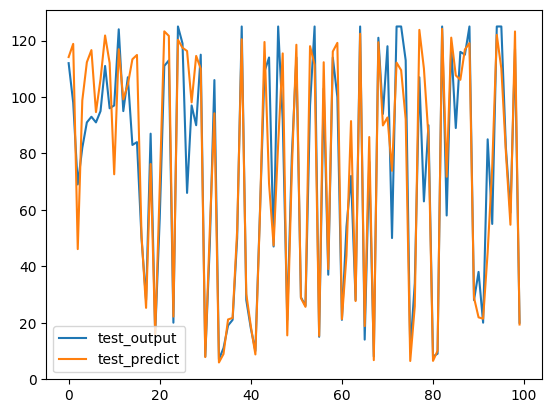

In [17]:
# 得出预测结果
test_predict = model.predict(test_input)
print(test_output.shape, test_predict.shape)
plt.plot(test_output, label='test_output')
plt.plot(test_predict, label='test_predict')
plt.legend()
plt.show()

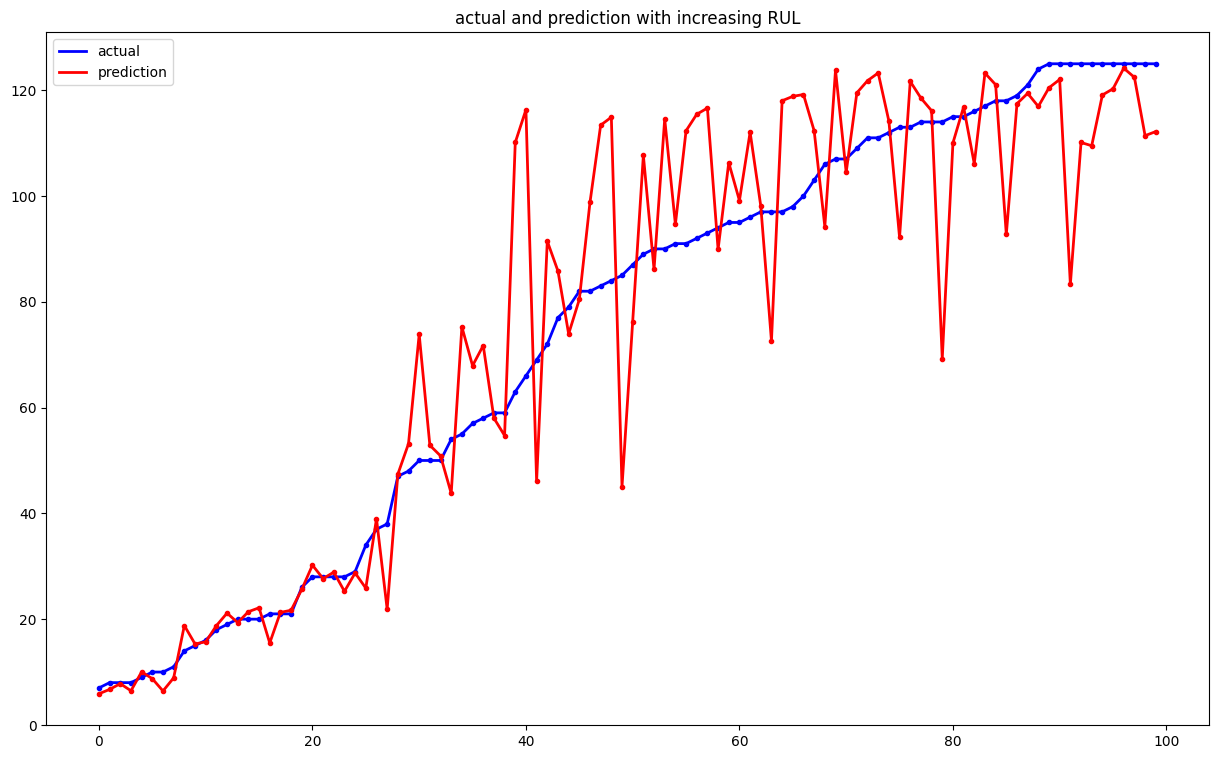

In [18]:
# 绘制对比图象
index = np.argsort(test_output)
test_output = np.sort(test_output)
test_predict = np.array([test_predict[i] for i in index])
plt.figure(1, figsize=(15, 9))
plt.title('actual and prediction with increasing RUL')
plt.plot(test_output, 'ob', ms=3)
plt.plot(test_output, 'b', lw=2, label='actual')
plt.legend(loc='upper left')
plt.plot(test_predict, 'or', ms=3)
plt.plot(test_predict, 'r', lw=2, label='prediction')
plt.legend(loc='upper left')
plt.show()

4/4 [==============================] - 0s 4ms/step


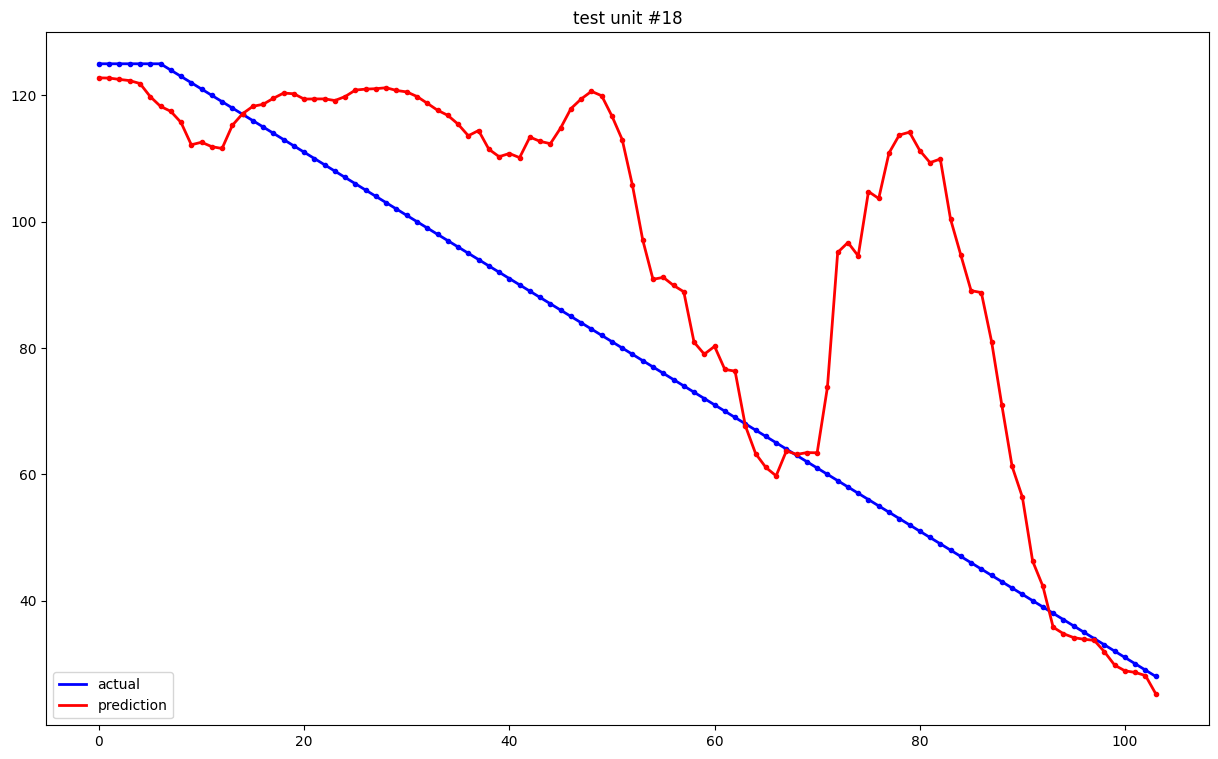

4/4 [==============================] - 0s 5ms/step


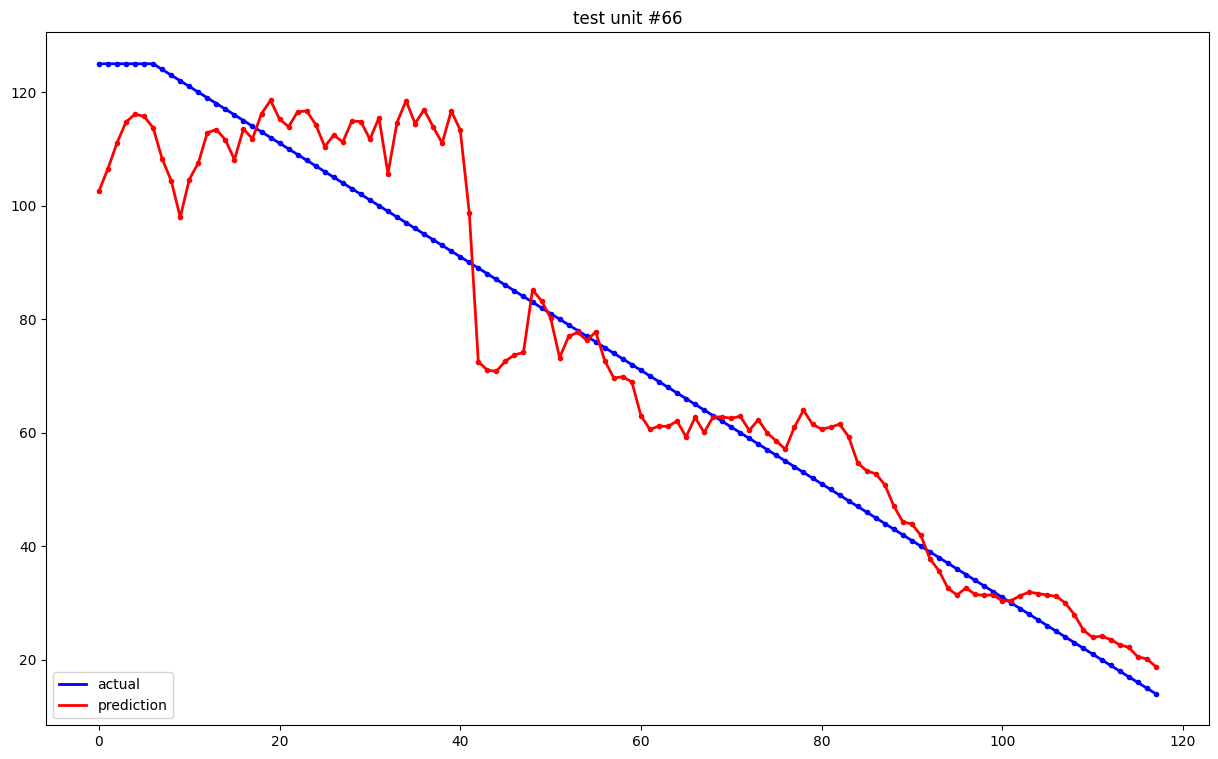

6/6 [==============================] - 0s 5ms/step


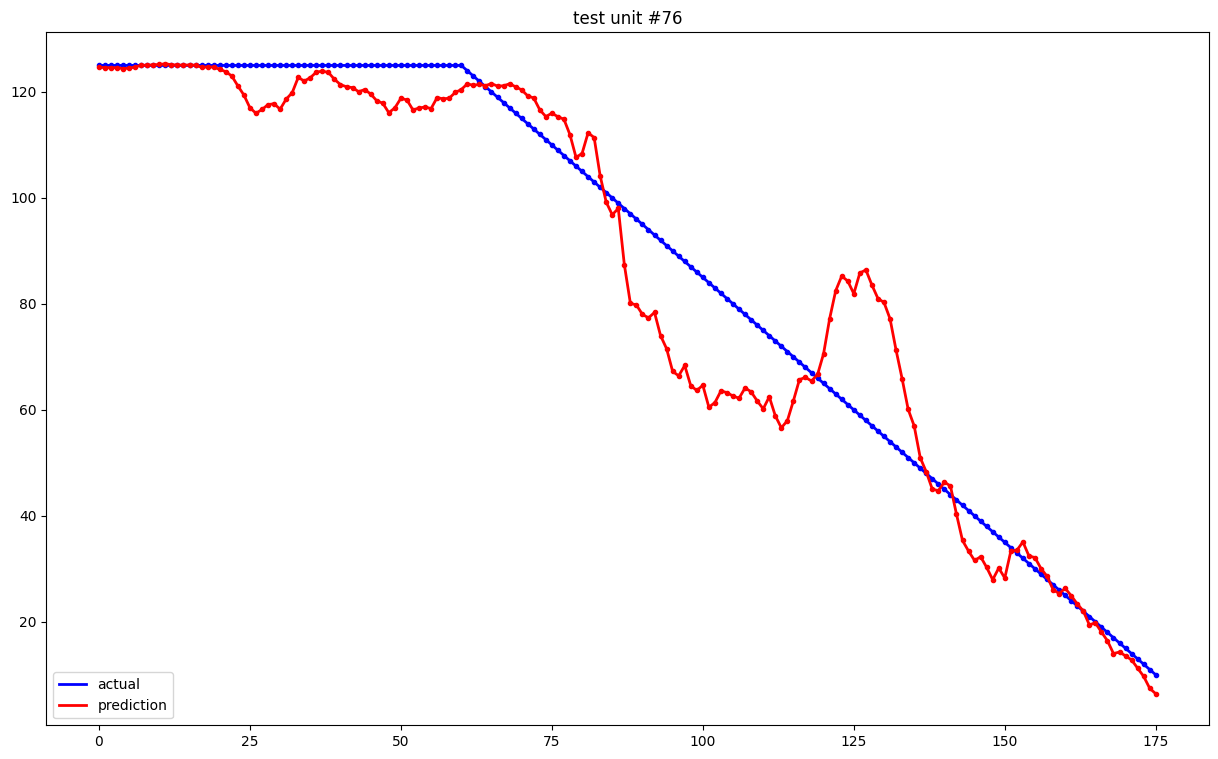

6/6 [==============================] - 0s 5ms/step


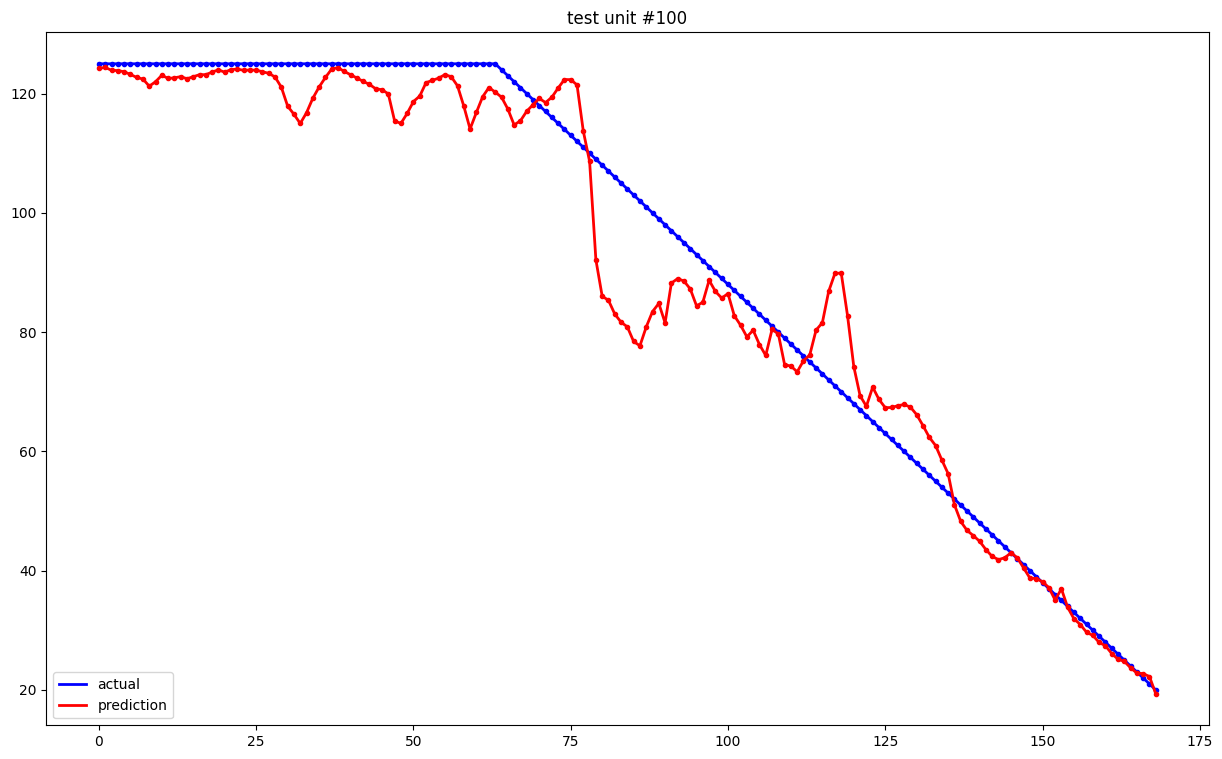

319/319 [==============================] - 1s 4ms/step


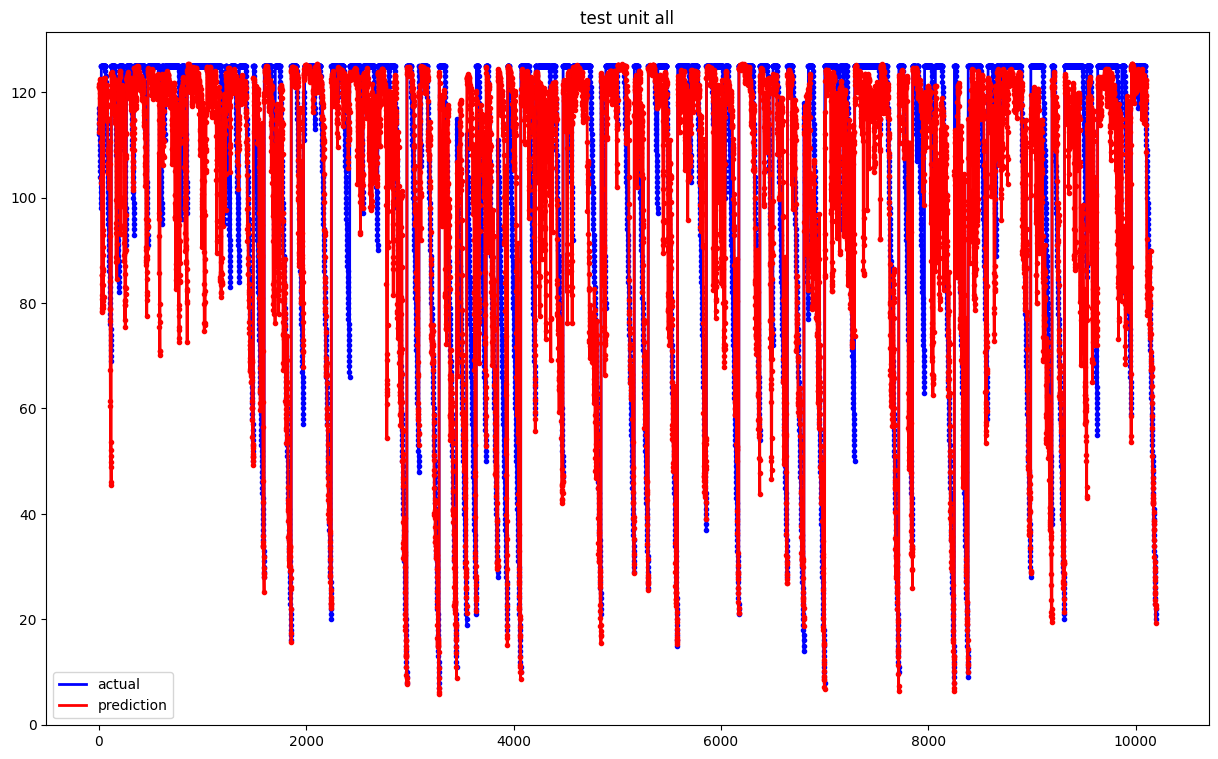

In [19]:
DrawUnit(df,18, model)
DrawUnit(df,66, model)
DrawUnit(df,76, model)
DrawUnit(df,100, model)
DrawUnitall(df, model)